There is a Pipeline in the end of the notebook. To run it, you need to import libraries and compile utils

In [1]:
%%capture
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install git+https://github.com/facebookresearch/segment-anything.git

In [2]:
import os
import requests
from pathlib import Path

import numpy as np
from PIL import Image
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import PILToTensor

In [ ]:
import kagglehub

path = kagglehub.dataset_download("tokhchukovdanil/scannet-scene-0a7cc12c0e")

In [ ]:
DATA_PATH = Path(path)
MASKS_PATH = DATA_PATH / "gt_semantic_2d" / "render_semantic_npy"
IMAGES_PATH = DATA_PATH / "images_0a7cc"

device = "cuda" if torch.cuda.is_available() else "cpu"

# Utils

In [4]:
import cv2

BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White


def visualize_bbox(img, bbox, color=BOX_COLOR, thickness=2, mode="hw"):
    """Visualizes a single bounding box on the image"""
    if mode == "hw":
        x_min, y_min, w, h = bbox
        cv2.rectangle(img, (x_min, y_min), (x_min + w, y_min + h), color=color, thickness=thickness)
    elif mode == "xy":
        x_min, y_min, x_max, y_max = bbox
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img


def visualize(image, bboxes):
    img = image.copy()
    for bbox in bboxes:
        img = visualize_bbox(img, bbox)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [5]:
def visualize_segmentation(image, mask):
    mask = mask.astype(bool).astype(np.uint8)
    img = image.copy()

    # Dilate the segmentation mask to expand the area
    dilated_mask = cv2.dilate(
        mask, np.ones((10, 10), np.uint8), iterations=1
    )

    # Create a mask of the surroundings by subtracting the original segmentation mask
    surroundings_mask = dilated_mask - mask

    img[surroundings_mask > 0] = [255, 120, 255]
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [6]:
def crop_image_with_bbox(image, bbox):
    X, Y, W, H = bbox
    cropped_image = image[Y : Y + H, X : X + W]
    return cropped_image

def crop_image_by_mask_white(image, mask):
    binary_mask = mask["segmentation"]
    white_canvas = np.ones_like(image) * 255
    cropped_image = np.where(binary_mask[..., None] > 0, image, white_canvas)
    cropped_image = crop_image_with_bbox(cropped_image, mask["bbox"])
    return cropped_image

def crop_image_by_mask_background(image, mask):
    cropped_image = crop_image_with_bbox(image, mask["bbox"])
    return cropped_image

# Dataset

In [32]:
from torchvision.io import read_image

class SceneDataset(Dataset):
    def __init__(self, masks_path: Path, imgs_path: Path, transforms=None):
        self.masks_path = masks_path
        self.imgs_path = imgs_path
        self.obj_names = []
        for i in self.imgs_path.iterdir():
            self.obj_names.append(i.stem)
        self.transforms = transforms

    def __len__(self):
        return len(self.obj_names)

    def __getitem__(self, idx):
        obj_name = self.obj_names[idx]
        mask_path = self.masks_path / (obj_name + ".npy")
        img_path = self.imgs_path / (obj_name + ".JPG")
        mask = np.load(mask_path)
        img = Image.open(img_path)
        if self.transforms is not None:
            img = self.transforms(img)

        return mask, img

In [33]:
scene_ds = SceneDataset(MASKS_PATH, IMAGES_PATH, np.array)

In [34]:
mask, img = scene_ds[0]
mask.shape, img.shape

((811, 1440), (811, 1440, 3))

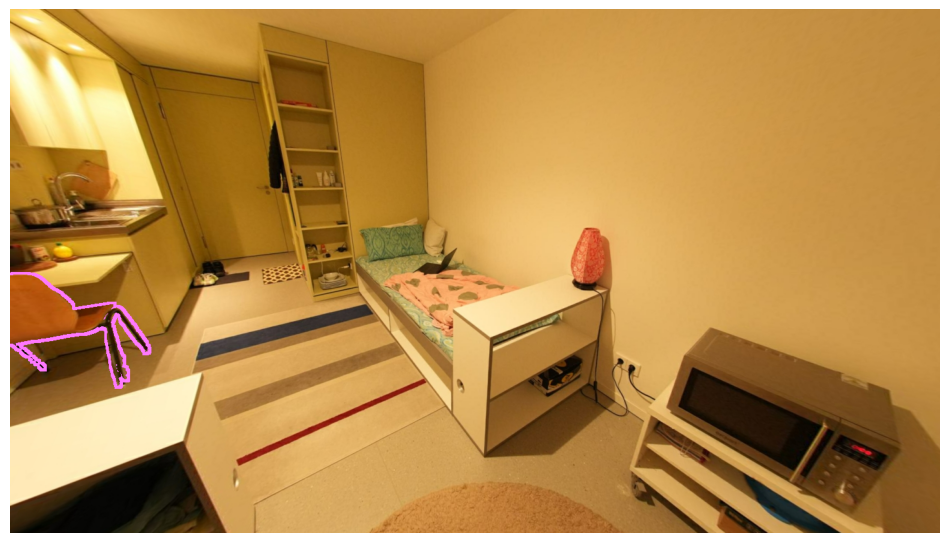

In [53]:
visualize_segmentation(img, mask == 8)

# SAM

### Load model

In [10]:
if not os.path.exists("/kaggle/sam_vit_h_4b8939.pth"):
    url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
    response = requests.get(url)
    
    with open("/kaggle/sam_vit_h_4b8939.pth", "wb") as f:
        f.write(response.content)

In [11]:
# https://github.com/facebookresearch/segment-anything?tab=readme-ov-file
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

sam = sam_model_registry["vit_h"](checkpoint="/kaggle/sam_vit_h_4b8939.pth").to(device)

/opt/conda/lib/python3.10/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


### Generate masks

In [12]:
mask_generator = SamAutomaticMaskGenerator(sam)
masks_sam = []
images = []

for i in tqdm(range(0, len(scene_ds), 10), total=len(scene_ds) // 10):
    _, img = scene_ds[i]
    images.append(img)
    m = mask_generator.generate(img)
    masks_sam.append(m)

  0%|          | 0/34 [00:00<?, ?it/s]

This is one of the generated masks, and bounding box around the segmented area.

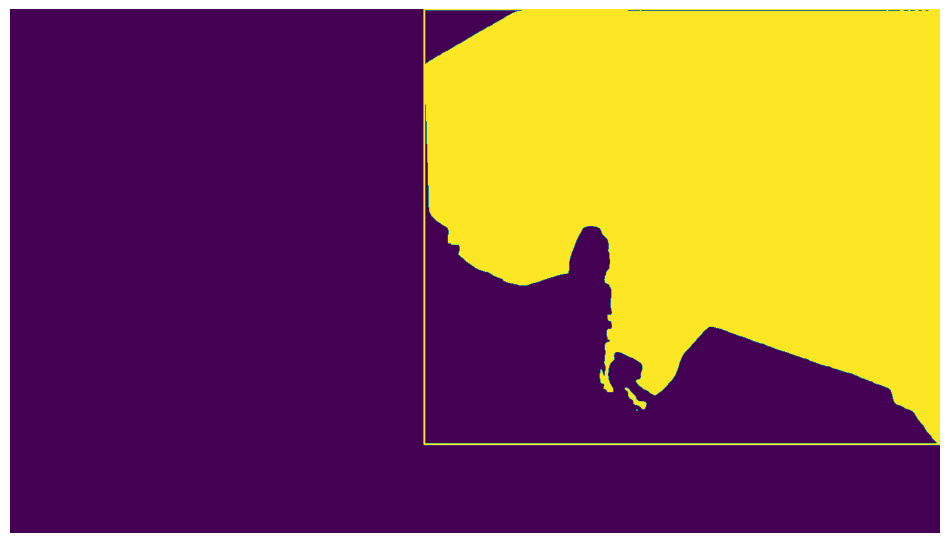

In [13]:
visualize(masks_sam[0][0]["segmentation"].astype(np.uint8) * 255, [masks_sam[0][0]["bbox"]])

### Create images from masks

In [16]:
segment_images = []

for masks, image in tqdm(zip(masks_sam, images), total=len(images)):
    seg_tmp_img = []
    for mask in masks:
        seg_img = crop_image_by_mask_background(image, mask)
        seg_tmp_img.append(seg_img)
    segment_images.append(seg_tmp_img)

  0%|          | 0/35 [00:00<?, ?it/s]

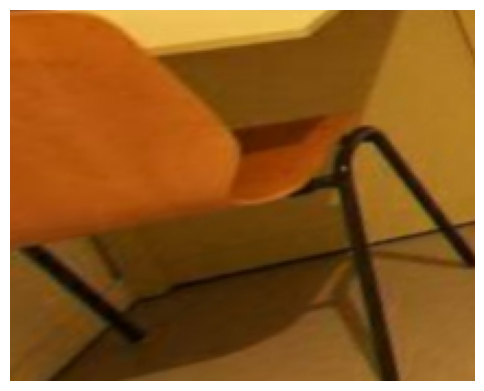

In [48]:
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(segment_images[0][27])
plt.show()

In [44]:
segment_images_white = []

for masks, image in tqdm(zip(masks_sam, images), total=len(images)):
    seg_tmp_img = []
    for mask in masks:
        seg_img = crop_image_by_mask_white(image, mask)
        seg_tmp_img.append(seg_img)
    segment_images_white.append(seg_tmp_img)

  0%|          | 0/35 [00:00<?, ?it/s]

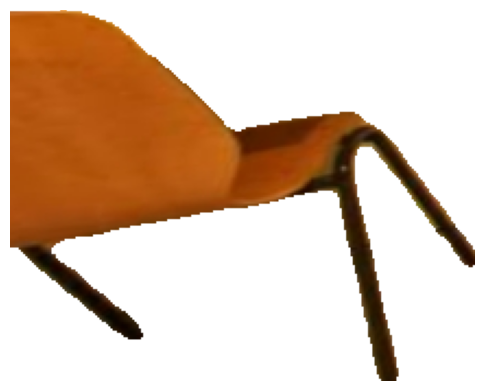

In [49]:
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(segment_images_white[0][27])
plt.show()

# CLIP

In [18]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [19]:
clip_model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 155MiB/s]


Here, I find cosine similarity between constructed masks and text prompt ("chair")

In [20]:
cos_similarity = []

text = clip.tokenize(["chair"]).to(device)

with torch.no_grad():
    for seg_images in tqdm(segment_images, total=len(segment_images)):
        tmp_cos_similar = []
        for seg_img in seg_images:
            img = Image.fromarray(seg_img.astype('uint8'), 'RGB')
            img = preprocess(img).unsqueeze(0).to(device)

            # https://github.com/openai/CLIP/blob/main/clip/model.py
            image_features = clip_model.encode_image(img)
            text_features = clip_model.encode_text(text)

            # normalized features
            image_features = image_features / image_features.norm(dim=1, keepdim=True)
            text_features = text_features / text_features.norm(dim=1, keepdim=True)
    
            # cosine similarity as logits
            logits_per_image = image_features @ text_features.t()
            tmp_cos_similar.append(logits_per_image[0][0].item())
        cos_similarity.append(tmp_cos_similar)

  0%|          | 0/35 [00:00<?, ?it/s]

In [22]:
cos_similarity[0][27]

0.30224609375

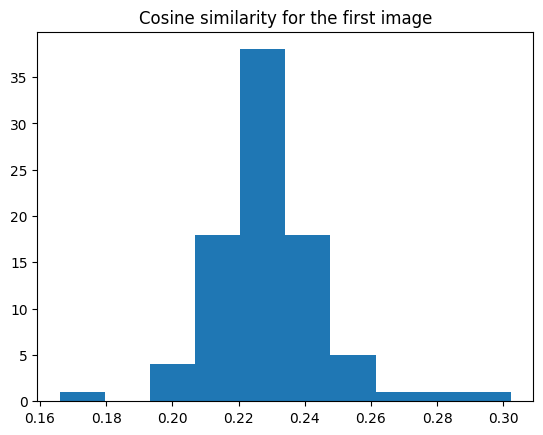

In [24]:
plt.hist(cos_similarity[0])
plt.title("Cosine similarity for the first image")
plt.show()

That means, that there exists a threshold, that cuts chair's segmentation masks from other masks.

This threshold is somewhere inside [0.26, 0.30] segment

# Compute IoU

In [ ]:
def compute_iou(mask, pred_mask):
    intersection = np.sum((mask != 0) & (pred_mask != 0))
    union = np.sum((mask != 0) | (pred_mask != 0))
    if union == 0:
        return 1.0
    return intersection / union

def compute_mean_iou(cos_similarity, masks_sam, scene_ds, thresh, class_id = 8):
    indices_similarity = []
    for similarity_in_img in cos_similarity:
        tmp_indices = []
        for i, s in enumerate(similarity_in_img):
            if s > thresh:
                tmp_indices.append(i)
        indices_similarity.append(tmp_indices)

    iou_box = []
    for i, i_ds in enumerate(range(0, len(scene_ds), 10)):
        mask, img = scene_ds[i_ds]
        mask = mask == class_id
        pred_mask = np.zeros_like(mask)
        for segment_idx in indices_similarity[i]:
            pred_mask |= masks_sam[i][segment_idx]["segmentation"]
        iou = compute_iou(mask, pred_mask)
        iou_box.append(iou)

    return np.mean(iou_box)

In [62]:
thresh_grid = np.linspace(0.25, 0.35, 50)
thresh_iou = []

for thresh in tqdm(thresh_grid, total=len(thresh_grid)):
    iou_res = compute_mean_iou(cos_similarity, masks_sam, scene_ds, thresh)
    thresh_iou.append(iou_res)

  0%|          | 0/50 [00:00<?, ?it/s]

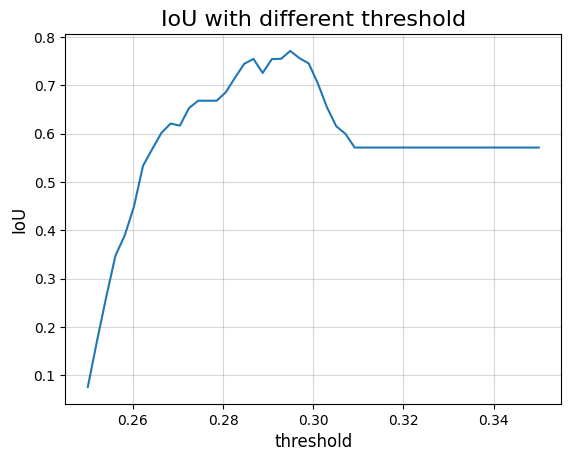

In [27]:
plt.plot(thresh_grid, thresh_iou)
plt.title("IoU with different threshold", fontsize=16)
plt.xlabel("threshold", fontsize=12)
plt.ylabel("IoU", fontsize=12)
plt.grid(True, alpha=0.5)
plt.show()

In [60]:
best_thresh = thresh_grid[np.argmax(thresh_iou)]

iou_res = compute_mean_iou(cos_similarity, masks_sam, scene_ds, best_thresh)

print(f"IoU score for chair class: {iou_res:.5f}")
print(f"Best threshold: {best_thresh:.5f}")

IoU score for chair class: 0.77143
Best threshold: 0.29490


# Pipeline

In [40]:
import clip
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

class Pipeline:
    def __init__(self, device):
        self.device = device
        self._load_sam()
        self._load_clip()

    def _load_sam(self):
        if not os.path.exists("/kaggle/sam_vit_h_4b8939.pth"):
            url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
            response = requests.get(url)
            
            with open("/kaggle/sam_vit_h_4b8939.pth", "wb") as f:
                f.write(response.content)

        self.sam = sam_model_registry["vit_h"](checkpoint="/kaggle/sam_vit_h_4b8939.pth").to(self.device)
        self.mask_generator = SamAutomaticMaskGenerator(self.sam)

    def _load_clip(self):
        clip_model, preprocess = clip.load("ViT-B/32", device=self.device)
        self.clip_model = clip_model
        self.clip_preprocess = preprocess

    def cosine_similarity(self, segment_images, text):
        cos_similarity = []

        text = clip.tokenize([text]).to(self.device)
        
        with torch.no_grad():
            for seg_img in segment_images:
                img = Image.fromarray(seg_img.astype('uint8'), 'RGB')
                img = self.clip_preprocess(img).unsqueeze(0).to(device)
    
                # https://github.com/openai/CLIP/blob/main/clip/model.py
                image_features = self.clip_model.encode_image(img)
                text_features = self.clip_model.encode_text(text)
    
                # normalized features
                image_features = image_features / image_features.norm(dim=1, keepdim=True)
                text_features = text_features / text_features.norm(dim=1, keepdim=True)
        
                # cosine similarity as logits
                logits_per_image = image_features @ text_features.t()
                cos_similarity.append(logits_per_image[0][0].item())

        return cos_similarity

    def get_segment(self, image, text, thresh = 0.29490):
        self.thresh = thresh
        masks = self.mask_generator.generate(image)
        segment_images = []
        for mask in masks:
            seg_img = crop_image_by_mask_background(image, mask)
            segment_images.append(seg_img)

        cos_similarity = self.cosine_similarity(segment_images, text)
        pred_mask = np.zeros_like(masks[0]["segmentation"])
        for i, cos_sim in enumerate(cos_similarity):
            if cos_sim > self.thresh:
                pred_mask |= masks[i]["segmentation"]
        return pred_mask

In [41]:
pipeline = Pipeline(device)

### Example from internet

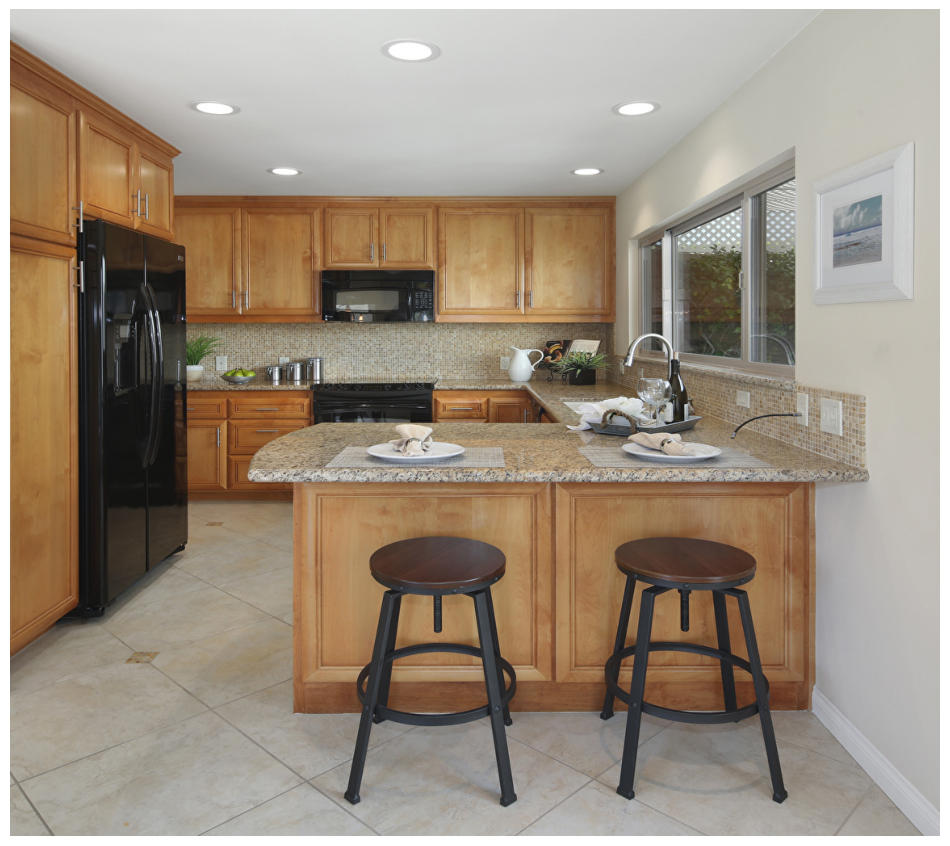

In [70]:
img_url = "https://s1.1zoom.me/big0/411/Interior_Design_Kitchen_Table_Chairs_553608_1152x1024.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(raw_image)
plt.show()

In [71]:
img = np.array(raw_image)
pred_mask = pipeline.get_segment(img, "chair", thresh=0.257)

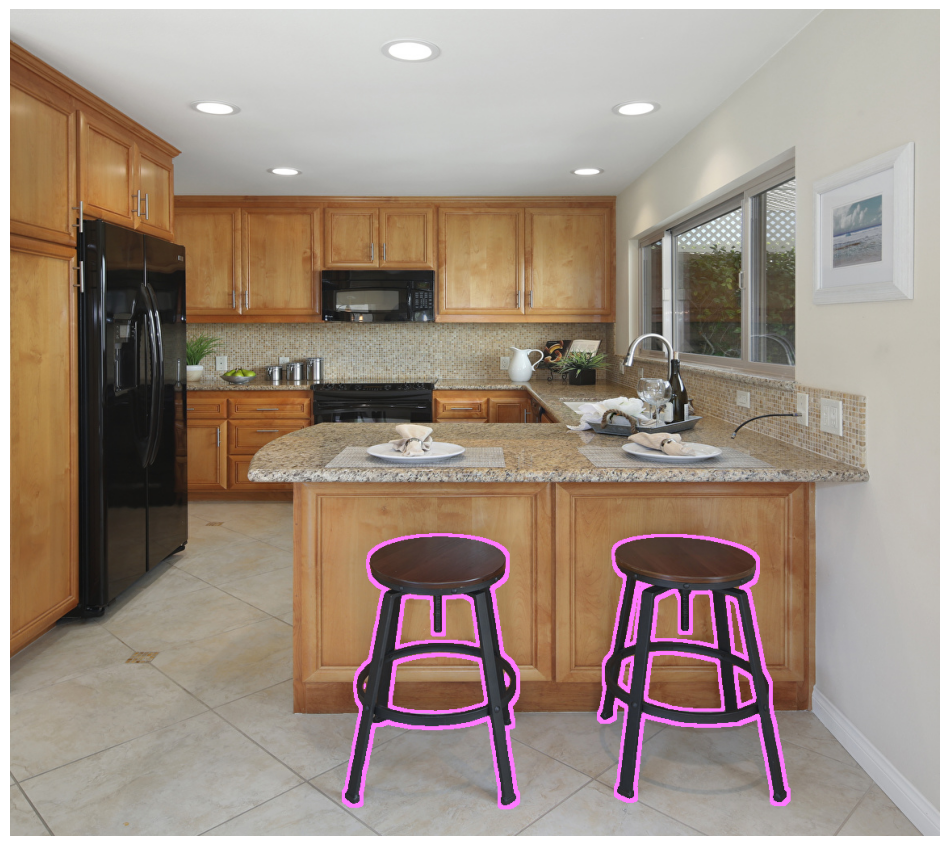

In [72]:
visualize_segmentation(img, pred_mask)

### Example from dataset

In [150]:
_, img = scene_ds[3]
pred_mask = pipeline.get_segment(img, "chair")

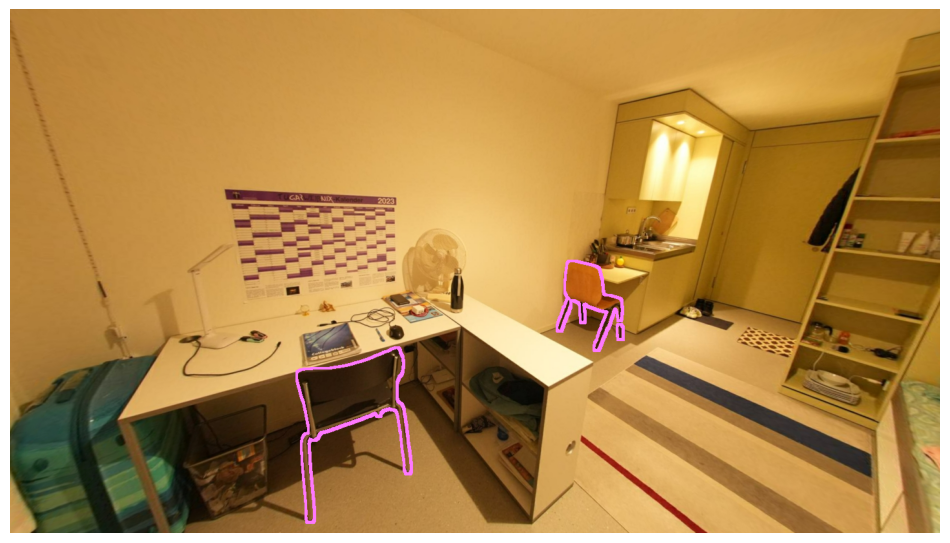

In [151]:
visualize_segmentation(img, pred_mask)

# Fails analysis

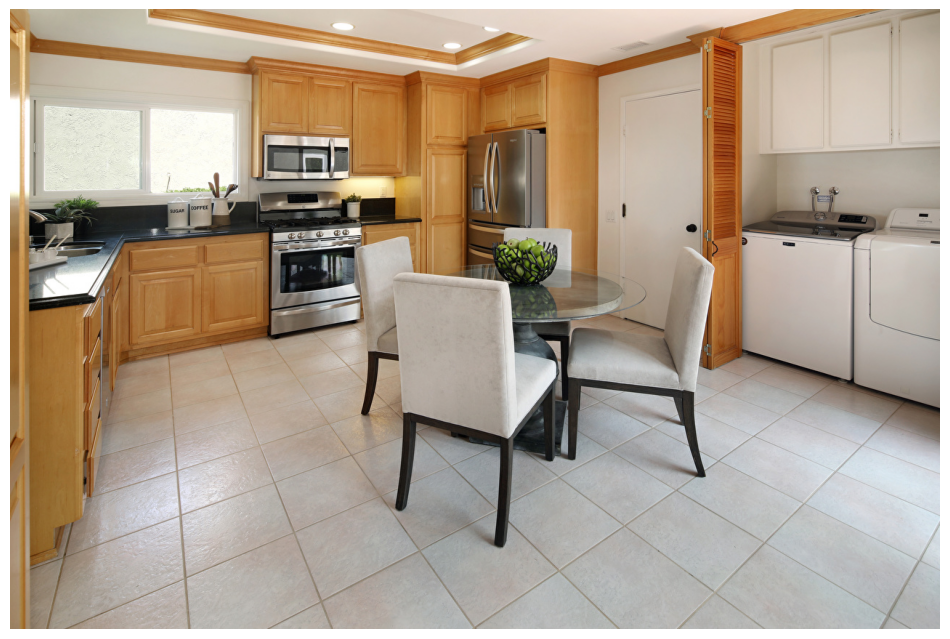

In [73]:
img_url = "https://s1.1zoom.ru/big0/989/Interior_Design_Kitchen_Chairs_608060_1280x853.jpg"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")

plt.figure(figsize=(12, 12))
plt.axis('off')
plt.imshow(raw_image)
plt.show()

In [74]:
img = np.array(raw_image)
pred_mask = pipeline.get_segment(img, "chair", thresh=0.257)

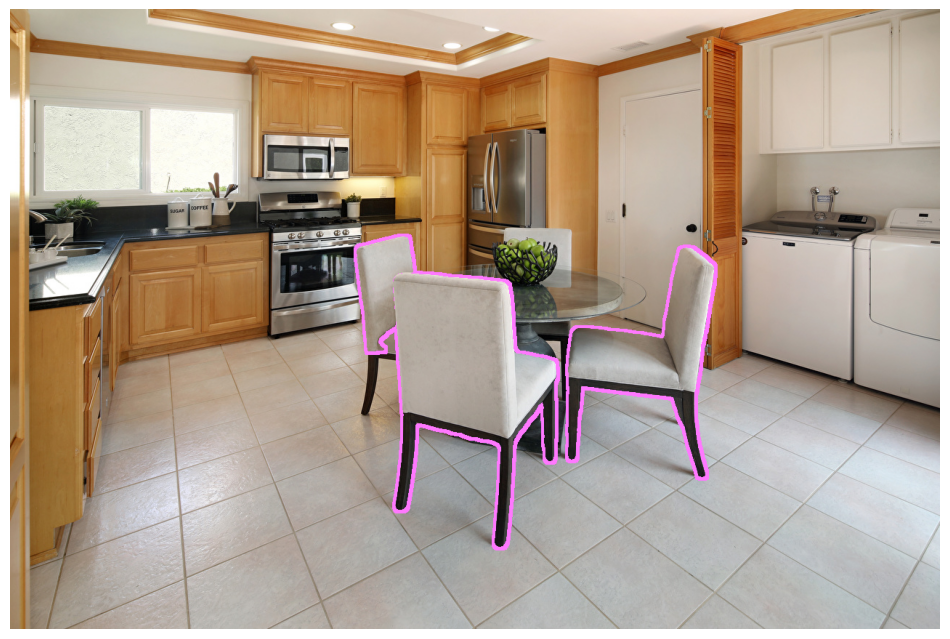

In [75]:
visualize_segmentation(img, pred_mask)

As we can see, models segmented the two front chairs very well, not so well the chair on the left, and didn't segment the chair in the background.

It happens, because model doesn't have world knowledge. It only watches at patches of images with chair on them, but the chair in the background can be identified only with contextual knowledge about the image. If the model would know, that there are 3 more chairs that stand around a table, it would likely have segmented the chair in the background.

Also, the chair on the left isn't segmented full. I think it is because the model doesn't see all parts of the chair.

# Text prompt analysis

In [203]:
_, img = scene_ds[15]
pred_mask = pipeline.get_segment(img, "bed", thresh=0.26)

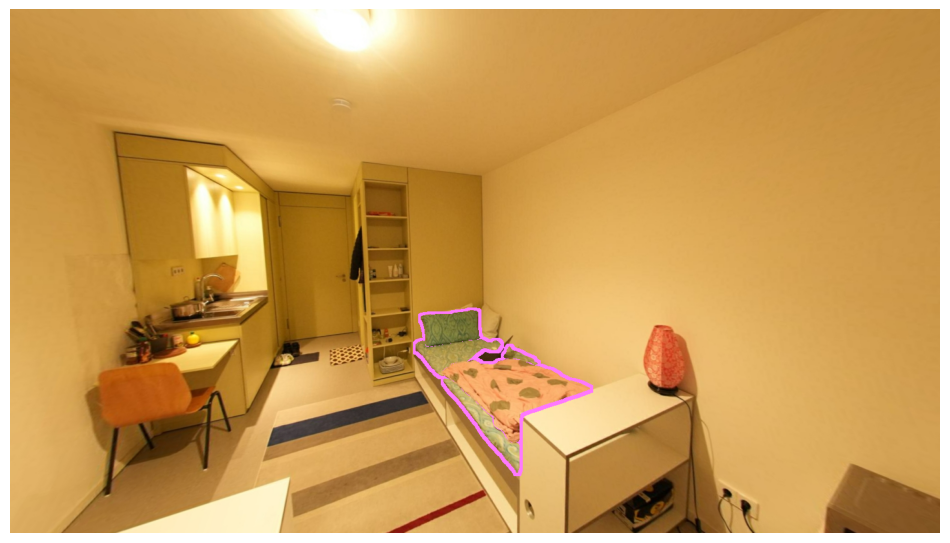

In [204]:
visualize_segmentation(img, pred_mask)

Prompt is just a "bed". The model identify only inner part of it. So, let's change prompt to take full bed with frame.

In [207]:
_, img = scene_ds[15]
pred_mask = pipeline.get_segment(img, "bed with frame", thresh=0.26)

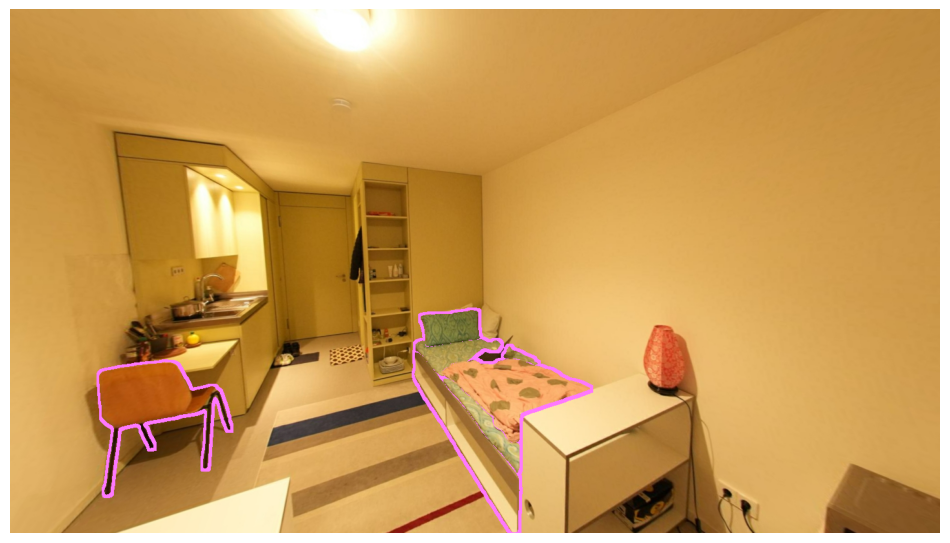

In [208]:
visualize_segmentation(img, pred_mask)

Haha, as we can see, it worked. But it also segmented a chair as a "bed with frame" (It's really a challenge to sleep on a chair).